# Examen 2 - Análisis de Datos


In [22]:
import pandas as pd
import numpy as np 
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [24]:
data = pd.read_csv('http://www2.udec.cl/~jorgecastillo/AirPassengers.txt', sep=',') 
data.rename(columns = {'#Passengers': "pasajeros", "Month":'date'}, inplace=True)
data.head()

,date,pasajeros
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Paso campo `mes` a datetime

In [25]:
data['date'] = pd.to_datetime(data.loc[:,'date'])

In [26]:
data.describe()

,pasajeros
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Vemos cómo es la serie de tiempo

Text(0.5, 1.0, 'Serie de tiempo - Pasajeros')

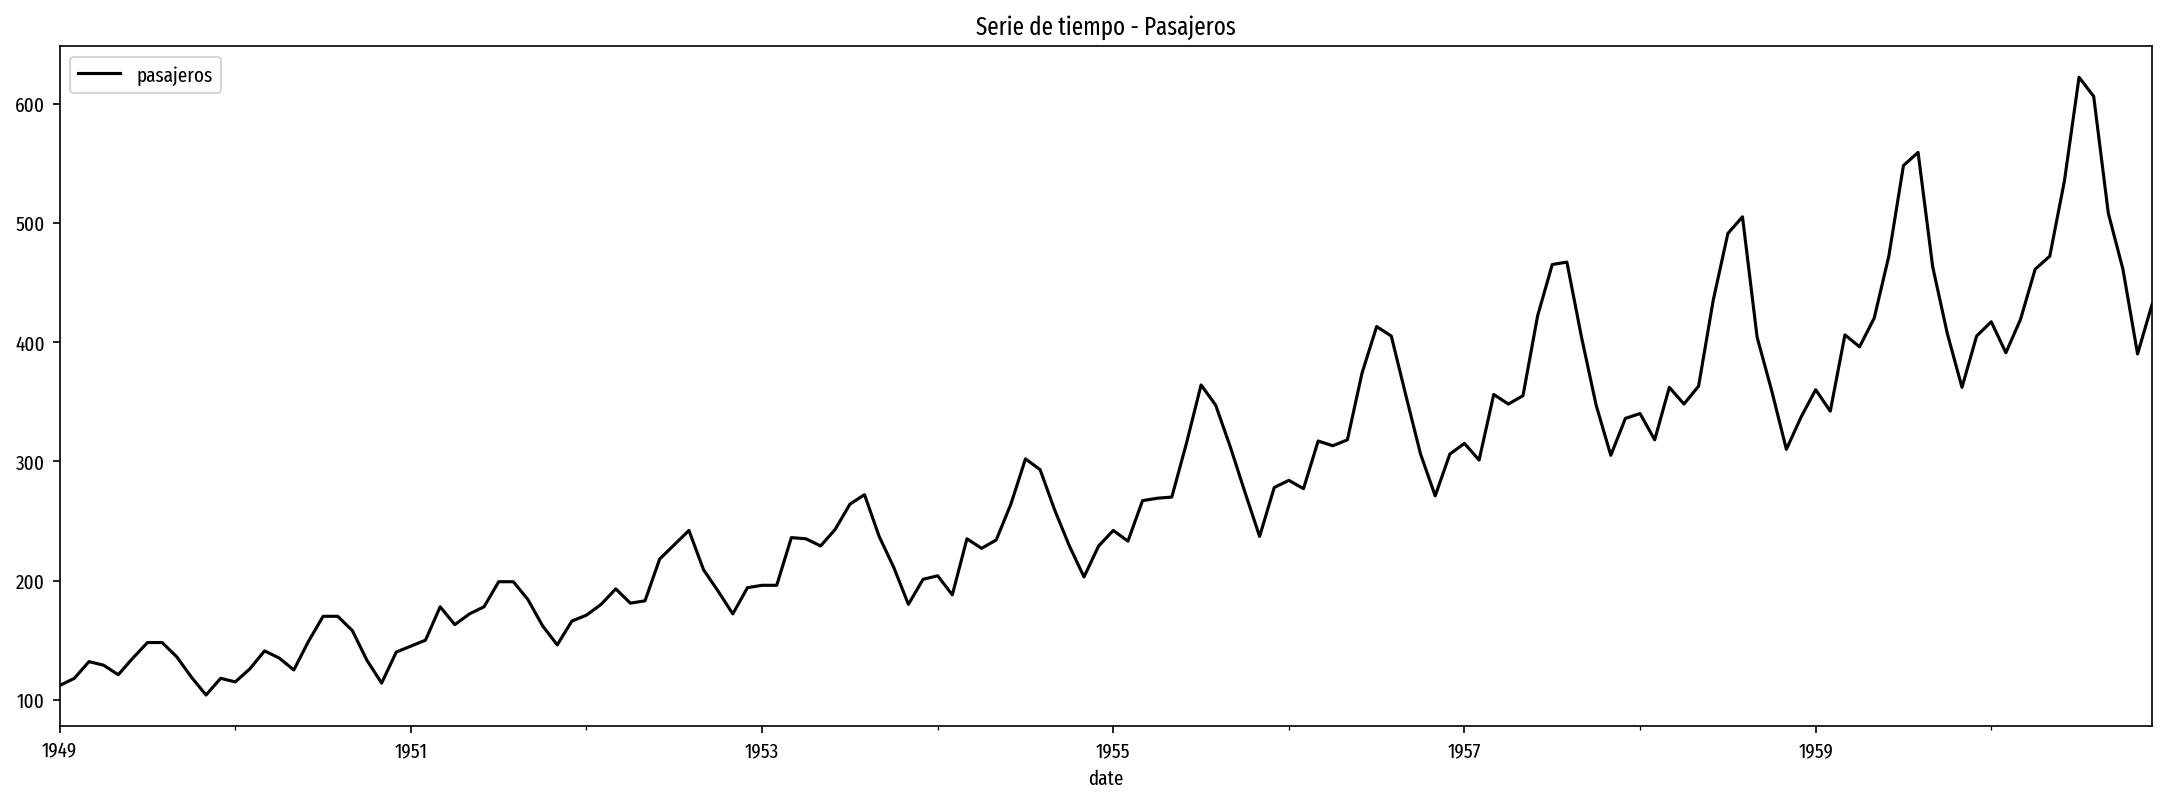

In [27]:
fig, ax = plt.subplots(figsize=(18,6))
data.plot(x='date',y='pasajeros',ax=ax, color='Black').set_title('Serie de tiempo - Pasajeros')

### 1.a) Comentar acerca de la tendencia:   
R:  El número de pasajeros aumenta a medida que pasa el tiempo lo cual indica que la tendencia es creciente. Esto queda claro al descomponer la serie de tiempo. Se puede ver que la pendiente que tiene la curva de tendencia es positiva.

### 1.b) Comentar acerca de su estacionalidad:  
R: Hay prescencia de componentes estacionales cada año. Esto puede ser debido a las temporadas de verano, en donde aumenta el número de viajes y por ende la cantidad de pasajeros.  Se aprecia claramente en el gráfico de estacionalidad al descomponer la serie de tiempo. En cada año hay un aumento considerable en la época de verano europeo. Además, podemos ver que la amplitud de la estacionalidad es mayor a medida que aumenta la pendiente de la tendencia, por lo que podemos concluir que la serie es **multiplicativa**.

### 1.c) Comentar sobre sus schocks aleatorios, irregularidades, etc.:  
R: A priori no se aprecia presencia de ciclicidad o shocks aleatorios en la serie de tiempo, tampoco de irregularidades.

Podemos ver que la serie presenta una tendencia creciente y que posee cierta estacionalidad. Además la amplitud de la estacionalidad es mayor a medida que aumenta la pendiente de la tendencia, por lo que sería una serie multiplicativa.

## Descompisición de la varianza

In [28]:
result=seasonal_decompose(data['pasajeros'], model='multiplicable', period=12)

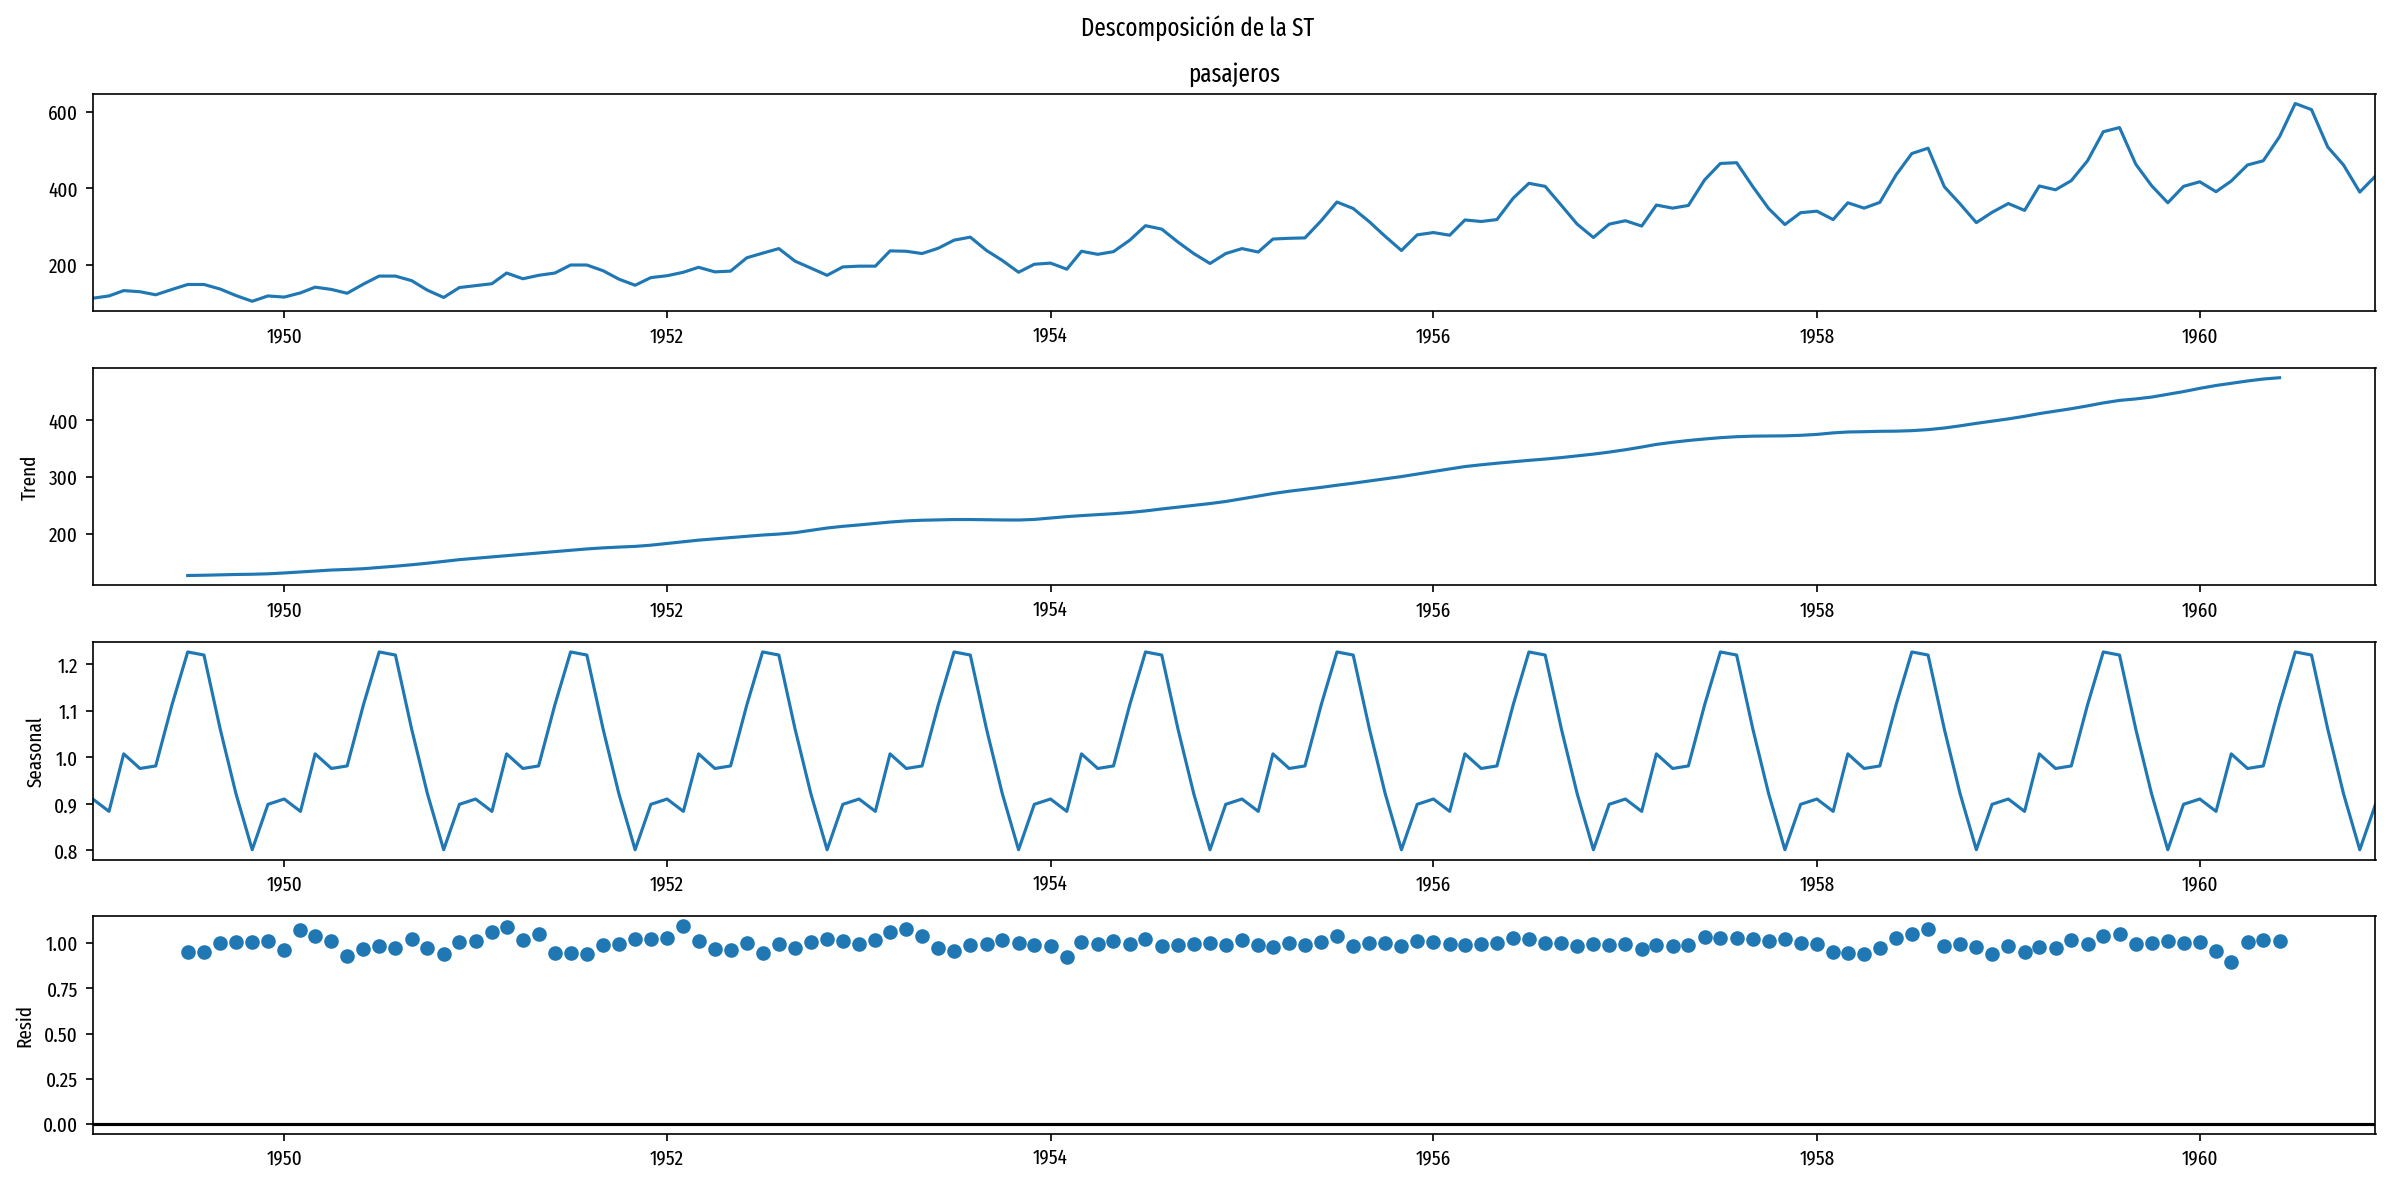

In [29]:
decomposition = seasonal_decompose(
    data.set_index('date').pasajeros,
    period=12,
    model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(16, 8)
fig.suptitle('Descomposición de la ST')
fig.tight_layout()

Utilizando STL

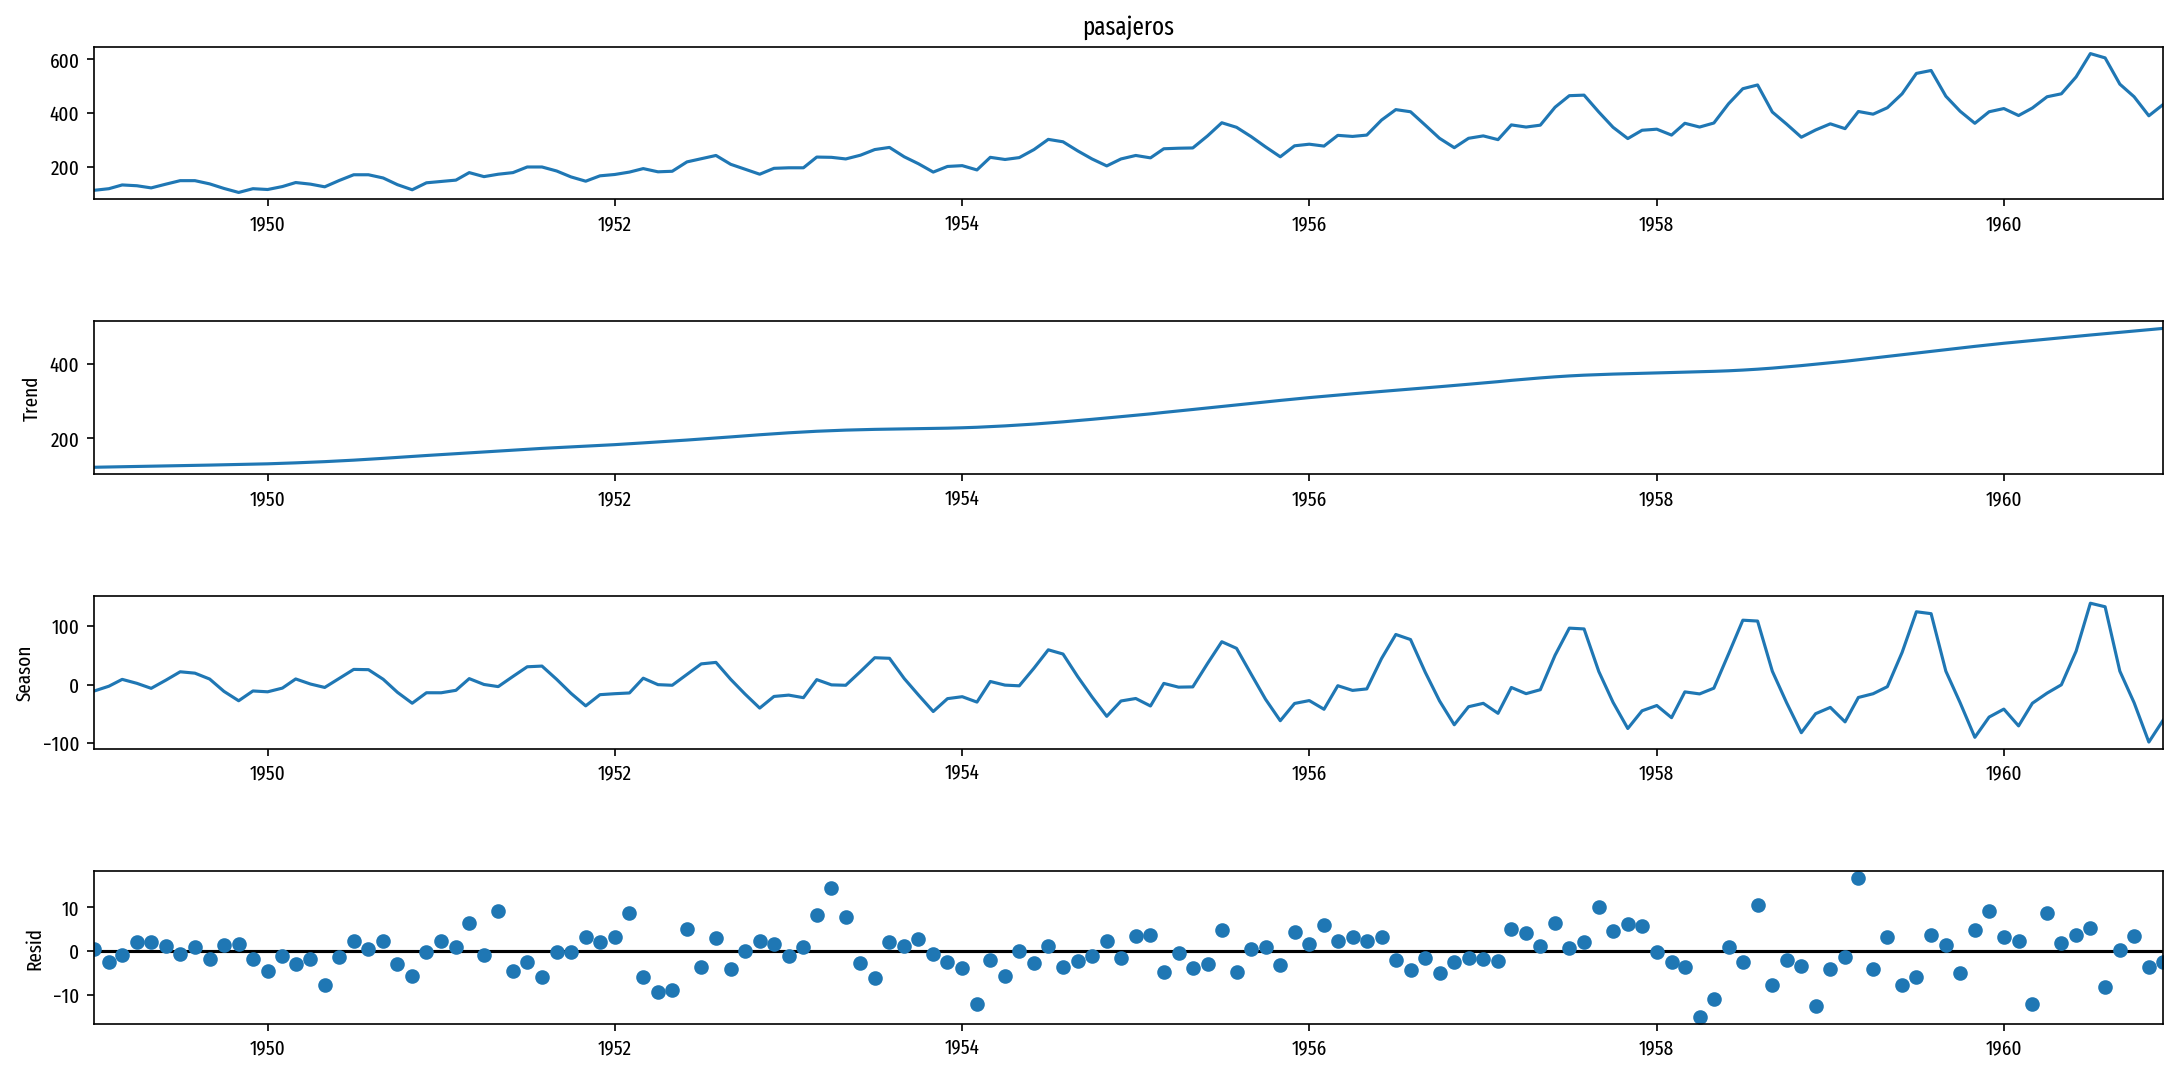

In [30]:

decomposition2 = STL(data.set_index('date').pasajeros, period=12).fit()

fig2 = decomposition2.plot()
fig2.set_size_inches(16, 8)